In [20]:
from keras.layers.core import Dense, Dropout, SpatialDropout1D
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from numpy import array
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D,MaxPooling1D
from keras.layers.recurrent import LSTM
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [2]:
INPUT_FILE = "C:/Users/meeta/Desktop/Work/TwitterStockPrediction/data.csv"
GLOVE_MODEL = "C:/Users/meeta/Desktop/Work/GlobalEnglish/glove.6B.100d.txt"
MAX_SEQUENCE_LENGTH = 100
VOCAB_SIZE = 20000
EMBED_SIZE = 100
BATCH_SIZE = 256
NUM_EPOCHS = 10
NUM_FILTERS = 32
NUM_WORDS = 3

In [3]:
print("reading data...")
df = pd.read_csv(INPUT_FILE)
print(len(df))
#df = df[np.isfinite(df['domain1_score'])]

reading data...
18994


In [4]:
embeddings_index = {}
f = open(GLOVE_MODEL, encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [5]:
counter = collections.Counter()
text = df.Tweet
maxlen = 0
for line in text:
    sent = line.strip()
    words = [x.lower() for x in nltk.word_tokenize(sent)]
    if len(words) > maxlen:
        maxlen = len(words)

In [6]:
text = df.Tweet
tokenizer = Tokenizer(VOCAB_SIZE)
tokenizer.fit_on_texts(text)
all_x = tokenizer.texts_to_sequences(text)

In [7]:
W = pad_sequences(all_x, maxlen=maxlen)
sentiment = df.Sentiment.values.reshape((df.Sentiment.shape[0], 1))
W = np.append(W, sentiment, 1)
maxlen = maxlen + 1
print(W.shape)

(18994, 92)


In [12]:
sp_5 = df['T-5'].values.reshape((df['T-5'].shape[0], 1))
W = np.append(W, sp_5, 1)
maxlen = maxlen + 1
print(W.shape)

(18994, 93)


In [13]:
sp_4 = df['T-4'].values.reshape((df['T-4'].shape[0], 1))
W = np.append(W, sp_4, 1)
maxlen = maxlen + 1
print(W.shape)

(18994, 94)


In [14]:
sp_3 = df['T-3'].values.reshape((df['T-3'].shape[0], 1))
W = np.append(W, sp_3, 1)
maxlen = maxlen + 1
print(W.shape)

(18994, 95)


In [15]:
sp_2 = df['T-2'].values.reshape((df['T-2'].shape[0], 1))
W = np.append(W, sp_2, 1)
maxlen = maxlen + 1
print(W.shape)

(18994, 96)


In [16]:
sp_1 = df['T-1'].values.reshape((df['T-1'].shape[0], 1))
W = np.append(W, sp_1, 1)
maxlen = maxlen + 1
print(W.shape)

(18994, 97)


In [17]:
print("Converting labels to One Hot Vectors...")
Label = df.Label
encoder = LabelBinarizer()
#Y = encoder.fit_transform(score)
Y = np_utils.to_categorical(Label)

Converting labels to One Hot Vectors...


In [18]:
print("Train-Test split")
Xtrain, Xtest, Ytrain, Ytest = train_test_split(W, Y, test_size=0.3, random_state=42)
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

Train-Test split
(13295, 97) (5699, 97) (13295, 2) (5699, 2)


In [24]:

model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=maxlen, trainable=True))
model.add(Conv1D(filters=NUM_FILTERS, kernel_size=NUM_WORDS, activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(maxlen))
model.add(Dense(2, activation="softmax"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("model_name", monitor='val_acc', mode='auto', verbose=1, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1)

history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(Xtest, Ytest), callbacks=[checkpoint, earlyStopping, reduceLR])

Train on 13295 samples, validate on 5699 samples
Epoch 1/10
13295/13295 [==============================] - 51s 4ms/step - loss: 0.6141 - acc: 0.6551 - val_loss: 0.5770 - val_acc: 0.6922

Epoch 00001: val_acc improved from -inf to 0.69223, saving model to model_name
Epoch 2/10
13295/13295 [==============================] - 47s 4ms/step - loss: 0.4915 - acc: 0.7619 - val_loss: 0.5615 - val_acc: 0.7187

Epoch 00002: val_acc improved from 0.69223 to 0.71872, saving model to model_name
Epoch 3/10
13295/13295 [==============================] - 47s 4ms/step - loss: 0.3489 - acc: 0.8450 - val_loss: 0.6130 - val_acc: 0.7152

Epoch 00003: val_acc did not improve
Epoch 4/10
13295/13295 [==============================] - 47s 4ms/step - loss: 0.2429 - acc: 0.8965 - val_loss: 0.7596 - val_acc: 0.7031

Epoch 00004: val_acc did not improve
Epoch 5/10
13295/13295 [==============================] - 47s 4ms/step - loss: 0.1807 - acc: 0.9254 - val_loss: 0.8261 - val_acc: 0.7164

Epoch 00005: val_acc did n

Text(0.5,1,'Train vs Validation Accuracy')

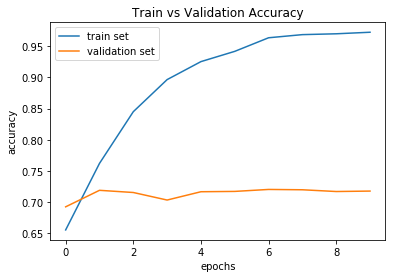

In [25]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train set', 'validation set'], loc='best')
plt.title('Train vs Validation Accuracy')